In [40]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib.pyplot as plt

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value.'''

def universal_func(So=2000, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(350,340,6)):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cp = 1005.7 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization
        
        RH1 = 0.9 #Relative Humidity
        RH2 = 0.8 
        #RH3 = 0.3
        
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        ws_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        w_1 = RH1 * ws_1
        q1 = w_1/(1+w_1)
        q1_s = ws_1/(1+ws_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        '''
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        q1 = RH1 * q1_s
        q2 = RH2 * q2_s #specific humidity
        q3 = RH3 * q3_s #specific humidity
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport
        '''
        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        k3 = 0.08 # relates the strength of convection to the cloud fraction
        #Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        def tau(T,Tft):
            tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
            return tau
            
        epsilon_2 = 1/(1+tau(T2,273))
        #epsilon_3 = 1/(1+tau(T3,273))
        #epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        #epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        #Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        #Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        #Eq6_WTG = T2 - T3

        #Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp*T1 + L*q1 - (Cp*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        #OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        
        if assumption == 'WTG': 
            #Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG
        elif assumption == 'WBG':
            #Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        
        if index==0:
            return (Eq2, Eq3,Eq7)
        if index==1:
            return(q1,q2,alpha_p,epsilon_2,OLR_day)
        
    index=0
    T1, T2, Fc = fsolve(equations,p_guess)
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    q1,q2,alpha_p,epsilon_2, OLR_day = equations((T1, T2, Fc))
    return (T1, T2, Fc, fc_2, q1,q2,alpha_p,epsilon_2,OLR_day)

In [41]:
universal_func(So=4000,assumption='WTG')

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(350.0,
 340.0,
 6.0,
 0.15567281192442506,
 0.3390635491051437,
 0.34135009015245765,
 0.2316622588512268,
 0.19828144123480776,
 727.505098810393)

In [42]:
universal_func(So=3400, assumption='WBG',\
p_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153))

ValueError: too many values to unpack (expected 3)

In [43]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG, OLR_day_arr_WBG, OLR_night_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

initial_guess = (300,270,20)
for idx,s in enumerate(so):
    print(idx,s)
    T1_arr_WBG[idx], T2_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
        q1_arr_WBG[idx],q2_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx], \
        OLR_day_arr_WBG[idx] = universal_func(So = s, assumption  = 'WBG',p_guess=initial_guess)
    initial_guess = (T1_arr_WBG[idx], T2_arr_WBG[idx], Fc_arr_WBG[idx])
    #print('end of loop ',initial_guess)

0 1000.0
1 1035.3535353535353
2 1070.7070707070707
3 1106.060606060606
4 1141.4141414141413
5 1176.7676767676767
6 1212.121212121212
7 1247.4747474747476
8 1282.828282828283
9 1318.1818181818182
10 1353.5353535353536
11 1388.888888888889
12 1424.2424242424242
13 1459.5959595959596
14 1494.949494949495
15 1530.3030303030305
16 1565.6565656565658
17 1601.0101010101012
18 1636.3636363636365
19 1671.7171717171718
20 1707.0707070707072
21 1742.4242424242425
22 1777.7777777777778
23 1813.1313131313132
24 1848.4848484848485
25 1883.8383838383838
26 1919.1919191919192
27 1954.5454545454545
28 1989.8989898989898
29 2025.2525252525254
30 2060.606060606061
31 2095.9595959595963
32 2131.3131313131316
33 2166.666666666667
34 2202.0202020202023
35 2237.3737373737376
36 2272.727272727273
37 2308.0808080808083
38 2343.4343434343436
39 2378.787878787879
40 2414.1414141414143
41 2449.4949494949497
42 2484.848484848485
43 2520.2020202020203
44 2555.5555555555557
45 2590.909090909091
46 2626.2626262626263

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log


In [44]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG, OLR_day_arr_WTG, OLR_night_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

initial_guess = (300,270,20)
for idx,s in enumerate(so):
    print(idx,s)
    T1_arr_WTG[idx], T2_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
        q1_arr_WTG[idx],q2_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx], \
        OLR_day_arr_WTG[idx] = universal_func(So = s, assumption  = 'WTG',p_guess=initial_guess)
    initial_guess = (T1_arr_WTG[idx], T2_arr_WTG[idx], Fc_arr_WTG[idx])
    #print('end of loop ',initial_guess)

0 1000.0
1 1035.3535353535353
2 1070.7070707070707
3 1106.060606060606
4 1141.4141414141413
5 1176.7676767676767
6 1212.121212121212
7 1247.4747474747476
8 1282.828282828283
9 1318.1818181818182
10 1353.5353535353536
11 1388.888888888889
12 1424.2424242424242
13 1459.5959595959596
14 1494.949494949495
15 1530.3030303030305
16 1565.6565656565658
17 1601.0101010101012
18 1636.3636363636365
19 1671.7171717171718
20 1707.0707070707072
21 1742.4242424242425
22 1777.7777777777778
23 1813.1313131313132
24 1848.4848484848485
25 1883.8383838383838
26 1919.1919191919192
27 1954.5454545454545
28 1989.8989898989898
29 2025.2525252525254
30 2060.606060606061
31 2095.9595959595963
32 2131.3131313131316
33 2166.666666666667
34 2202.0202020202023
35 2237.3737373737376
36 2272.727272727273
37 2308.0808080808083
38 2343.4343434343436
39 2378.787878787879
40 2414.1414141414143
41 2449.4949494949497
42 2484.848484848485
43 2520.2020202020203
44 2555.5555555555557
45 2590.909090909091
46 2626.2626262626263

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log


In [45]:
def plot_diff(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.suptitle('WBG - WTG', fontsize = 16)
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    #arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    #arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(4) ]

    nele = len(arr_list)
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
    unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
    
    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1, 
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  =plt.subplot(nrows, ncols, idx + 1)

        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        plt.xlim(1000,3000)
        #plt.ylim(160,320)
        if idx ==3: 
            plt.legend(frameon = False)
    plt.savefig("WTG_WBG_diff_T1-T4.png")
    plt.close()

    return fig
plot_diff(so)

(5, 100)


ValueError: Number of rows must be a positive integer, not (3,)

<Figure size 864x720 with 0 Axes>

(4, 100)
(4, 100)


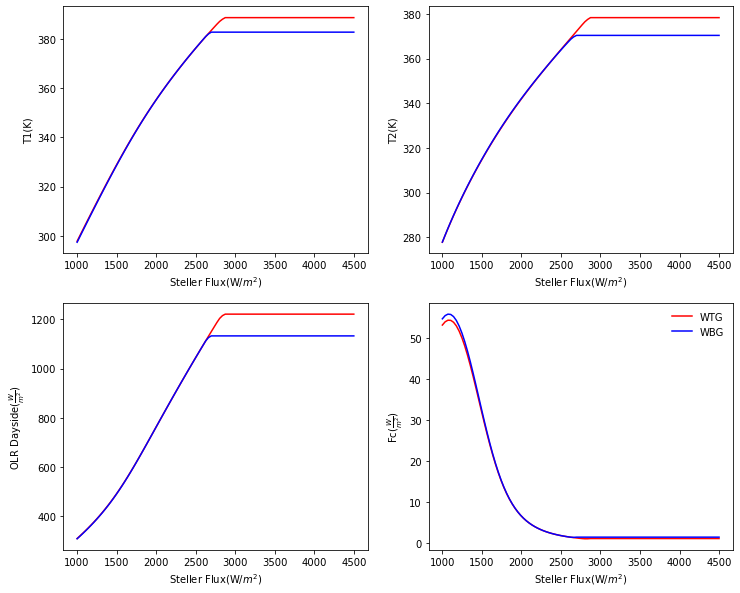

In [46]:
def plot_across_so(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            #arr_list = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
            #arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
            #arr_list = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG,fc_arr_WBG ]
            arr_list = [T1_arr_WBG, T2_arr_WBG, OLR_day_arr_WBG, Fc_arr_WBG]
        elif assumption == 'WTG':
            #arr_list = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
            #arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
            #arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG,fc_arr_WTG]
            arr_list = [T1_arr_WTG, T2_arr_WTG, OLR_day_arr_WTG, Fc_arr_WTG]
        
        nele = len(arr_list)
        #name_list = ['T1','T2','T3','T4']
        #unit_list = ['K','K','K','K']
        #name_list = ['q1','q2','q3','fc']
        #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
        #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
        #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
        name_list = ['T1','T2', 'OLR Dayside', 'Fc']
        unit_list = ['K', 'K', r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
        
        
        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax  =plt.subplot(nrows, ncols, idx + 1)

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,3000)
            #plt.ylim(160,320)
            if idx ==3: 
                plt.legend(frameon = False)
    plt.savefig("WTG_WBG_compare_T1-T4.png")
    plt.close()

    return fig

plot_across_so(so)

### plotting

In [ ]:
def plot_8panels(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
   
    
    
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list_WTG = [OLR_day_arr_WTG, OLR_night_arr_WTG]
    #arr_list_WBG  = [OLR_day_arr_WBG, OLR_night_arr_WBG]
    #arr_list_WBG = [T1_arr_WBG,]
    
    
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '']
    #name_list = ['OLR_day', 'OLR_night']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
    
    nele = len(name_list)
    ncols = 2
    nrows = nele
    fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
    ax = axs[0][0]
    
    #nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = arr_list_WBG
        elif assumption == 'WTG':
            arr_list = arr_list_WTG
        
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax = axs[idx][0]

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            #ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,3000)
            #plt.ylim(50,350)
            if idx == nele - 1: 
                ax.legend(frameon = False)
                ax.set_xlabel(xlab +'('+ xunit +')')
    
    
    ### plot difference
    #plt.suptitle('WBG - WTG', fontsize = 16)

    
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(nele) ]

    for idx, arr in enumerate(arr_list):
        ax = axs[idx][1]
        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        
        #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,3000)
        #plt.ylim(50,350)
        if idx == nele -1: 
            plt.legend(frameon = False)
            plt.xlabel(xlab +'('+ xunit +')')
            
    #axs[0][0].set_ylim(50,350)
    plt.savefig("WTG_WBG_q1-q3.png")
    plt.close()
    
    #fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
        
        
    

    return fig
plot_8panels(so)

In [ ]:
fig = plt.figure(figsize =(12,6))
plt.rcParams['savefig.facecolor']='white'

for i_assumption, assumption in enumerate(['WTG','WBG']): 
    ax = plt.subplot(1,2,1+i_assumption)
    ax.set_title(assumption)
    
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    
    if assumption == 'WBG':
        arr_list = arr_list_WBG
        epsilon_arr = epsilon_2_arr_WBG
    elif assumption == 'WTG': 
        arr_list = arr_list_WTG
        epsilon_arr = epsilon_2_arr_WTG
    
    ax.plot(so, arr_list[0], color = 'r', linestyle = '-', label = 'T1')
    ax.plot(so, arr_list[1], color = 'b', linestyle = '-', label = 'T2')
    ax.plot(so, arr_list[2], color = 'b', linestyle = '--', label = 'T3')
    ax.plot(so, arr_list[3], color = 'r', linestyle = '--', label = 'T4')
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k')
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k', label = r'$\epsilon_2 = 1$')
    if i_assumption == 1:
        ax.legend(frameon = False)
    plt.xlabel('Steller Flux' +'(W/m^2)')
    #plt.xlim(1000,3000)
    plt.savefig('WTG_WBG_eps2.png', facecolor=fig.get_facecolor(), transparent=False)
